In [1]:
import numpy as np
from keras.src.saving.saving_api import load_model
from keras.src.utils.image_utils import img_to_array
from sklearn.model_selection import train_test_split
from keras.src.utils.numerical_utils import to_categorical
from sklearn.metrics import accuracy_score
from PIL import Image
import tensorflow as tf
from skimage import feature
import os
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
import logging
from ast import literal_eval
from joblib import load
import csv

import matplotlib.pyplot as plt

# Gán nhãn cho từng dự đoán

In [2]:
#dictionary to label all traffic signs class.
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)',      
            2:'Speed limit (50km/h)',       
            3:'Speed limit (60km/h)',      
            4:'Speed limit (70km/h)',    
            5:'Speed limit (80km/h)',      
            6:'End of speed limit (80km/h)',     
            7:'Speed limit (100km/h)',    
            8:'Speed limit (120km/h)',     
           9:'No passing',   
           10:'No passing veh over 3.5 tons',     
           11:'Right-of-way at intersection',     
           12:'Priority road',    
           13:'Yield',     
           14:'Stop',       
           15:'No vehicles',       
           16:'Veh > 3.5 tons prohibited',       
           17:'No entry',       
           18:'General caution',     
           19:'Dangerous curve left',      
           20:'Dangerous curve right',   
           21:'Double curve',      
           22:'Bumpy road',     
           23:'Slippery road',       
           24:'Road narrows on the right',  
           25:'Road work',    
           26:'Traffic signals',      
           27:'Pedestrians',     
           28:'Children crossing',     
           29:'Bicycles crossing',       
           30:'Beware of ice/snow',
           31:'Wild animals crossing',      
           32:'End speed + passing limits',      
           33:'Turn right ahead',     
           34:'Turn left ahead',       
           35:'Ahead only',      
           36:'Go straight or right',      
           37:'Go straight or left',      
           38:'Keep right',     
           39:'Keep left',      
           40:'Roundabout mandatory',     
           41:'End of no passing',      
           42:'End no passing veh > 3.5 tons' }

# Tính toán đặc trưng ảnh

In [3]:
def compute_hog(image_path):
    try:
        image = Image.open(image_path)
        image = image.convert("L")
        image = image.resize((128, 128))

        hog, _ = feature.hog(np.array(image), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             visualize=True, transform_sqrt=True, block_norm='L2-Hys')
        return hog
    except Exception as e:
        logging.error(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

### Thử với một ảnh

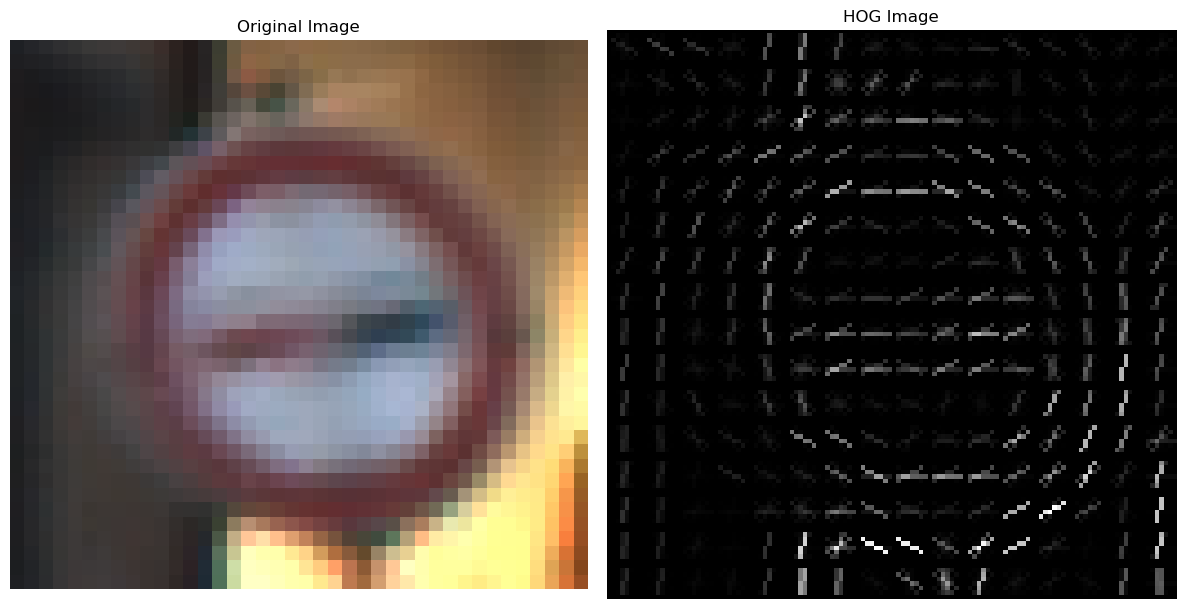

Kích thước của HOG features cho ảnh: (8100,)


In [4]:
def test_compute_hog(image_path):
    try:
        image = Image.open(image_path)
        image = image.convert("L")
        image = image.resize((128, 128))

        hog, _ = feature.hog(np.array(image), orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                             visualize=True, transform_sqrt=True, block_norm='L2-Hys')
        return hog, _
    except Exception as e:
        logging.error(f"Lỗi khi xử lý ảnh {image_path}: {e}")
        return None

# Đường dẫn tới thư mục chứa ảnh
image_folder = './data/test/'

# Tên file ảnh cần thử nghiệm
image_filename = "12578.png"

# Khởi tạo danh sách lưu trữ HOG features và hình ảnh
features = []
hog_images = []
original_images = []

# Tính toán HOG features và HOG images cho ảnh
image_path = os.path.join(image_folder, image_filename)
hog_feature, hog_image = test_compute_hog(image_path)
features.append(hog_feature)
hog_images.append(hog_image)
original_images.append(Image.open(image_path))

# Hiển thị hình ảnh gốc và HOG image
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.imshow(original_images[0])
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(hog_images[0], cmap=plt.cm.gray)
plt.title('HOG Image')
plt.axis('off')

plt.tight_layout()
plt.show()

# In ra kích thước của HOG features cho ảnh
print(f"Kích thước của HOG features cho ảnh: {np.array(features[0]).shape}")


### Tải dữ liệu và trích xuất đặc trưng

In [5]:
def load_data_from_csv(csv_file):
    data = []
    labels = []

    with open(csv_file, 'r') as file:
        lines = file.readlines()[1:]  # Bỏ qua dòng tiêu đề
        for line in lines:
            parts = line.strip().split(',')
            image_path = parts[-1]
            hog = compute_hog("./data/" + image_path)
            if hog is not None:
                data.append(hog)
                labels.append(int(parts[-2]))  # ClassId là phần thứ 2 từ cuối dòng
    return np.array(data), np.array(labels)

In [6]:
X_train, Y_train = load_data_from_csv("./data/Train.csv")

In [7]:
X_train

array([[0.23774285, 0.        , 0.03385776, ..., 0.08669832, 0.2857048 ,
        0.2857048 ],
       [0.        , 0.        , 0.        , ..., 0.31038459, 0.18627728,
        0.12943961],
       [0.32507678, 0.        , 0.04466683, ..., 0.23369199, 0.        ,
        0.        ],
       ...,
       [0.26788997, 0.        , 0.09320252, ..., 0.16436833, 0.        ,
        0.        ],
       [0.29785438, 0.13475587, 0.14077172, ..., 0.26428568, 0.26428568,
        0.06014992],
       [0.24760278, 0.09476172, 0.119992  , ..., 0.07105677, 0.        ,
        0.        ]])

In [47]:
X_test, Y_test = load_data_from_csv("./data/test.csv")

###  Thống kê dữ liệu

C:\Users\PC\AppData\Local\Temp\ipykernel_11856\3443763203.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


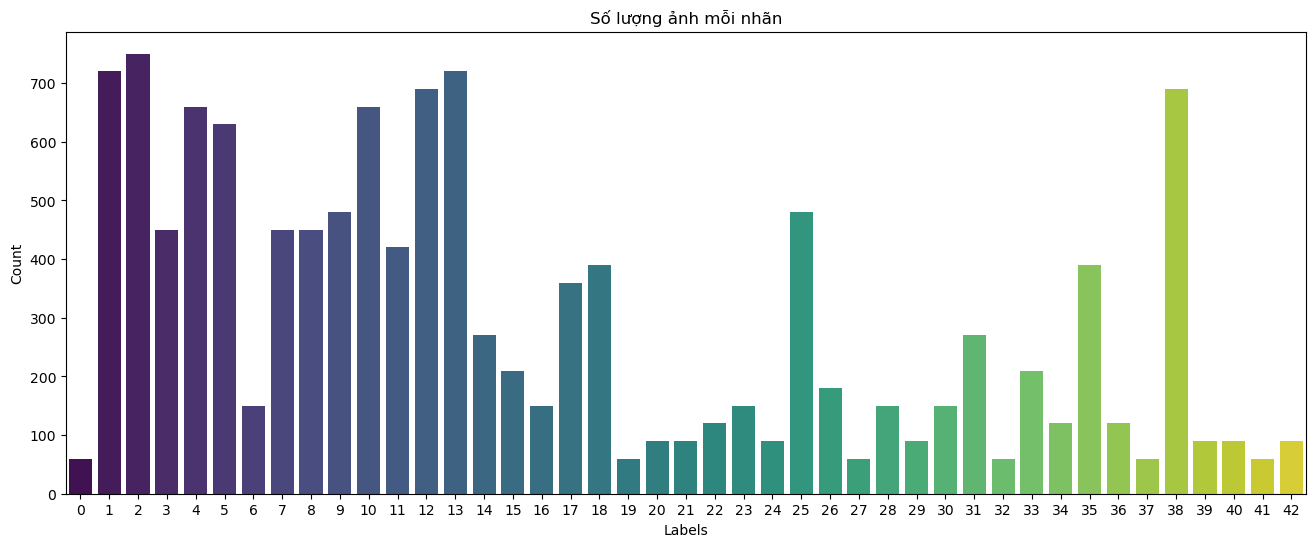

In [51]:
import seaborn as sns
unique, counts = np.unique(Y_test, return_counts=True)

# Tạo biểu đồ cột
plt.figure(figsize=(16, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Số lượng ảnh mỗi nhãn')
plt.show()

C:\Users\PC\AppData\Local\Temp\ipykernel_11856\3633194060.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


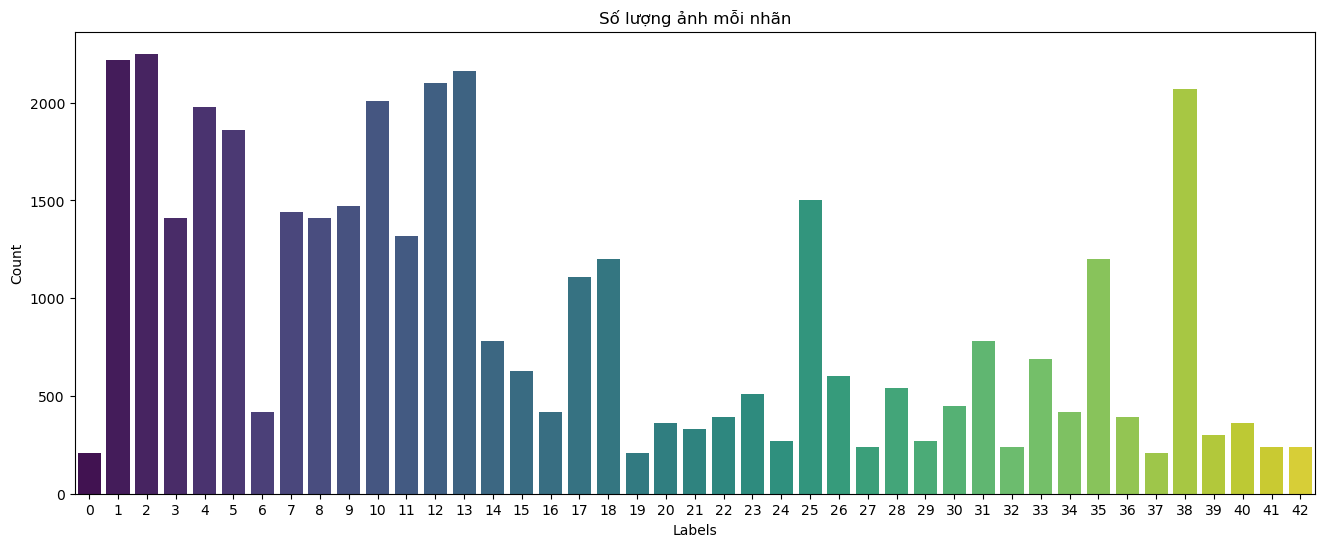

In [8]:
import seaborn as sns
unique, counts = np.unique(Y_train, return_counts=True)

# Tạo biểu đồ cột
plt.figure(figsize=(16, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Số lượng ảnh mỗi nhãn')
plt.show()

In [9]:
import numpy as np

# Giả sử y_train_resampled là mảng chứa các nhãn sau khi thực hiện over-sampling
unique, counts = np.unique(Y_train, return_counts=True)
label_counts = dict(zip(unique, counts))

print(label_counts)

{0: 210, 1: 2220, 2: 2250, 3: 1410, 4: 1980, 5: 1860, 6: 420, 7: 1440, 8: 1410, 9: 1470, 10: 2010, 11: 1320, 12: 2100, 13: 2160, 14: 780, 15: 630, 16: 420, 17: 1110, 18: 1200, 19: 210, 20: 360, 21: 330, 22: 390, 23: 510, 24: 270, 25: 1500, 26: 600, 27: 240, 28: 540, 29: 270, 30: 450, 31: 780, 32: 240, 33: 689, 34: 420, 35: 1200, 36: 390, 37: 210, 38: 2070, 39: 300, 40: 360, 41: 240, 42: 240}


### Xử lý dữ liệu không cân bằng

In [10]:
sampling_strategy = {
0: 1000, 1: 2220, 2: 2250, 
3: 1410, 4: 1980, 5: 1860,
6: 1000, 7: 1440, 8: 1410, 
9: 1470, 10: 2010, 11: 1320, 
12: 2100, 13: 2160, 14: 1000, 
15: 1000, 16: 1000, 17: 1110, 
18: 1200, 19: 1000, 20: 1000,
21: 1000, 22: 1000, 23: 1000,
24: 1000, 25: 1500, 26: 1000, 
27: 1000, 28: 1000, 29: 1000, 
30: 1000, 31: 1000, 32: 1000, 
33: 1000, 34: 1000, 35: 1200, 
36: 1000, 37: 1000, 38: 2070, 
39: 1000, 40: 1000, 41: 1000, 
42: 1000
}

In [40]:
from imblearn.over_sampling import SMOTE

# Giả sử X_train và y_train là dữ liệu và nhãn
smote = SMOTE(sampling_strategy=sampling_strategy, random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, Y_train)

C:\Users\PC\AppData\Local\Temp\ipykernel_11856\313957556.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=unique, y=counts, palette="viridis")


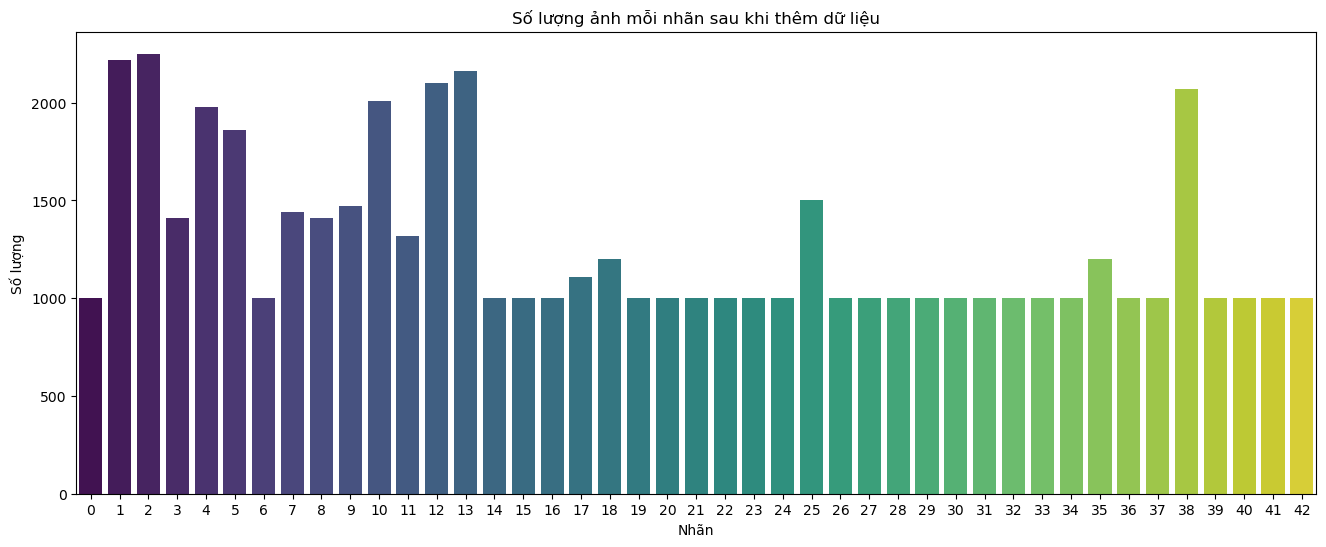

In [41]:
import seaborn as sns
unique, counts = np.unique(y_train_resampled, return_counts=True)

# Tạo biểu đồ cột
plt.figure(figsize=(16, 6))
sns.barplot(x=unique, y=counts, palette="viridis")
plt.xlabel('Nhãn')
plt.ylabel('Số lượng')
plt.title('Số lượng ảnh mỗi nhãn sau khi thêm dữ liệu')
plt.show()

# Chia tập dữ liệu 

In [42]:
from sklearn.model_selection import train_test_split

# Chia tập dữ liệu thành tập huấn luyện và tập còn lại
x_train, x_remaining, y_train, y_remaining = train_test_split(X_train_resampled, y_train_resampled, test_size=0.25, random_state=9)

# Tiếp tục chia tập còn lại thành tập kiểm thử và tập xác thực
x_test, x_val, y_test, y_val = train_test_split(x_remaining, y_remaining, test_size=0.4, random_state=15)

print(f'Tập huấn luyện: {x_train.shape}, Tập kiểm thử: {x_test.shape}, Tập xác thực: {x_val.shape}')
print(f'Nhãn huấn luyện: {y_train.shape}, Nhãn kiểm thử: {y_test.shape}, Nhãn xác thực: {y_val.shape}')

Tập huấn luyện: (41032, 8100), Tập kiểm thử: (8206, 8100), Tập xác thực: (5472, 8100)
Nhãn huấn luyện: (41032,), Nhãn kiểm thử: (8206,), Nhãn xác thực: (5472,)


# Tiến hành training với 3 model

### SVM

In [15]:
from sklearn import svm

model_svm = svm.LinearSVC(C=0.01)
model_svm.fit(x_train, y_train)

### KNN

In [16]:
model_knn = KNeighborsClassifier()
model_knn.fit(x_train, y_train) 

### Random Forest

In [17]:
from sklearn.ensemble import RandomForestClassifier

model_rf = RandomForestClassifier(n_estimators=100, random_state=42)
model_rf.fit(x_train, y_train)

### Lưu lại model

In [18]:
from joblib import dump

# dump(model_knn, 'knn_model_3.pkl')

# dump(model_svm, 'svm_model_3.pkl')

# dump(model_rf, 'rf_model_3.pkl')

# Đánh giá các model

In [60]:
model_svm = load('svm_model_3.pkl')
model_rf = load('rf_model_3.pkl')
model_knn = load('knn_model_3.pkl') 

### Đánh giá mô hình SVM

In [61]:
from sklearn.metrics import accuracy_score, classification_report

# Dự đoán nhãn của dữ liệu validation bằng mô hình SVM
y_pred_val_svm = model_svm.predict(X_test)

# Đánh giá mô hình SVM
accuracy_val_svm = accuracy_score(Y_test, y_pred_val_svm)
report_val_svm = classification_report(Y_test, y_pred_val_svm)

print("Đánh giá mô hình SVM trên dữ liệu validation:")
print(f"Accuracy: {accuracy_val_svm}")
print("Classification Report:")
print(report_val_svm)

Đánh giá mô hình SVM trên dữ liệu validation:
Accuracy: 0.9451306413301662
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        60
           1       0.93      0.91      0.92       720
           2       0.90      0.96      0.93       750
           3       0.89      0.85      0.87       450
           4       0.97      0.97      0.97       660
           5       0.84      0.88      0.86       630
           6       0.99      0.79      0.88       150
           7       0.91      0.93      0.92       450
           8       0.91      0.87      0.89       450
           9       0.99      0.97      0.98       480
          10       0.96      0.98      0.97       660
          11       0.95      0.94      0.95       420
          12       0.99      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       0.98      0.99      0.98       270
          15       0.95      1.00    

In [43]:
from sklearn.metrics import accuracy_score, classification_report

# Dự đoán nhãn của dữ liệu validation bằng mô hình SVM
y_pred_val_svm = model_svm.predict(x_val)

# Đánh giá mô hình SVM
accuracy_val_svm = accuracy_score(y_val, y_pred_val_svm)
report_val_svm = classification_report(y_val, y_pred_val_svm)

print("Đánh giá mô hình SVM trên dữ liệu validation:")
print(f"Accuracy: {accuracy_val_svm}")
print("Classification Report:")
print(report_val_svm)

Đánh giá mô hình SVM trên dữ liệu validation:
Accuracy: 0.9948830409356725
Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       108
           1       0.99      0.98      0.99       213
           2       0.99      0.98      0.98       230
           3       1.00      0.97      0.99       147
           4       0.98      1.00      0.99       190
           5       0.98      0.97      0.98       215
           6       1.00      1.00      1.00        95
           7       0.98      0.99      0.99       159
           8       0.97      0.96      0.97       149
           9       0.99      1.00      0.99       156
          10       0.99      1.00      0.99       177
          11       0.99      1.00      1.00       139
          12       1.00      1.00      1.00       206
          13       1.00      1.00      1.00       227
          14       1.00      1.00      1.00       109
          15       1.00      1.00    

### Đánh giá mô hình Random Forest

In [49]:
# Dự đoán nhãn của dữ liệu validation bằng mô hình Random Forest
y_pred_val_rf = model_rf.predict(X_test)

# Đánh giá mô hình Random Forest
accuracy_val_rf = accuracy_score(Y_test, y_pred_val_rf)
report_val_rf = classification_report(Y_test, y_pred_val_rf)

print("Đánh giá mô hình Random Forest trên dữ liệu validation:")
print(f"Accuracy: {accuracy_val_rf}")
print("Classification Report:")
print(report_val_rf)

Đánh giá mô hình Random Forest trên dữ liệu validation:
Accuracy: 0.9346793349168646
Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98        60
           1       0.95      0.87      0.91       720
           2       0.86      0.97      0.91       750
           3       0.97      0.84      0.90       450
           4       0.95      0.95      0.95       660
           5       0.82      0.90      0.86       630
           6       0.93      0.75      0.83       150
           7       0.89      0.92      0.91       450
           8       0.87      0.80      0.83       450
           9       0.96      0.97      0.97       480
          10       0.93      0.97      0.95       660
          11       0.91      0.96      0.93       420
          12       0.98      1.00      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      0.96      0.98       270
          15       0.98    

In [44]:
# Dự đoán nhãn của dữ liệu validation bằng mô hình Random Forest
y_pred_val_rf = model_rf.predict(x_val)

# Đánh giá mô hình Random Forest
accuracy_val_rf = accuracy_score(y_val, y_pred_val_rf)
report_val_rf = classification_report(y_val, y_pred_val_rf)

print("Đánh giá mô hình Random Forest trên dữ liệu validation:")
print(f"Accuracy: {accuracy_val_rf}")
print("Classification Report:")
print(report_val_rf)

Đánh giá mô hình Random Forest trên dữ liệu validation:
Accuracy: 0.9932383040935673
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       108
           1       1.00      0.97      0.98       213
           2       0.96      0.98      0.97       230
           3       0.99      0.95      0.97       147
           4       1.00      0.98      0.99       190
           5       0.97      0.97      0.97       215
           6       1.00      1.00      1.00        95
           7       0.99      0.99      0.99       159
           8       0.98      0.99      0.99       149
           9       0.97      0.99      0.98       156
          10       0.98      0.99      0.99       177
          11       1.00      1.00      1.00       139
          12       1.00      1.00      1.00       206
          13       1.00      1.00      1.00       227
          14       1.00      1.00      1.00       109
          15       1.00    

### Đánh giá mô hình KNN

In [48]:
# Dự đoán nhãn của dữ liệu validation bằng mô hình KNN
y_pred_val_knn = model_knn.predict(X_test)

# Đánh giá mô hình KNN
accuracy_val_knn = accuracy_score(Y_test, y_pred_val_knn)
report_val_knn = classification_report(Y_test, y_pred_val_knn)

print("Đánh giá mô hình KNN trên dữ liệu validation:")
print(f"Accuracy: {accuracy_val_knn}")
print("Classification Report:")
print(report_val_knn)

Đánh giá mô hình KNN trên dữ liệu validation:
Accuracy: 0.66270783847981
Classification Report:
              precision    recall  f1-score   support

           0       0.09      0.97      0.16        60
           1       0.87      0.41      0.55       720
           2       0.93      0.57      0.71       750
           3       0.67      0.46      0.54       450
           4       0.94      0.74      0.83       660
           5       0.53      0.67      0.59       630
           6       0.74      0.73      0.73       150
           7       0.84      0.68      0.75       450
           8       0.70      0.76      0.73       450
           9       0.95      0.45      0.61       480
          10       0.86      0.70      0.77       660
          11       1.00      0.08      0.15       420
          12       1.00      0.97      0.98       690
          13       1.00      0.99      1.00       720
          14       0.98      0.93      0.95       270
          15       0.30      0.99      

In [45]:
# Dự đoán nhãn của dữ liệu validation bằng mô hình KNN
y_pred_val_knn = model_knn.predict(x_val)

# Đánh giá mô hình KNN
accuracy_val_knn = accuracy_score(y_val, y_pred_val_knn)
report_val_knn = classification_report(y_val, y_pred_val_knn)

print("Đánh giá mô hình KNN trên dữ liệu validation:")
print(f"Accuracy: {accuracy_val_knn}")
print("Classification Report:")
print(report_val_knn)

Đánh giá mô hình KNN trên dữ liệu validation:
Accuracy: 0.9565058479532164
Classification Report:
              precision    recall  f1-score   support

           0       0.65      1.00      0.79       108
           1       0.98      0.91      0.94       213
           2       0.99      0.86      0.92       230
           3       0.97      0.85      0.91       147
           4       0.99      0.96      0.98       190
           5       0.94      0.92      0.93       215
           6       0.98      1.00      0.99        95
           7       0.99      0.89      0.94       159
           8       0.93      0.95      0.94       149
           9       1.00      0.93      0.96       156
          10       0.98      0.94      0.96       177
          11       1.00      0.81      0.89       139
          12       1.00      1.00      1.00       206
          13       1.00      1.00      1.00       227
          14       1.00      0.99      1.00       109
          15       0.64      1.00    

### Thử với một ảnh

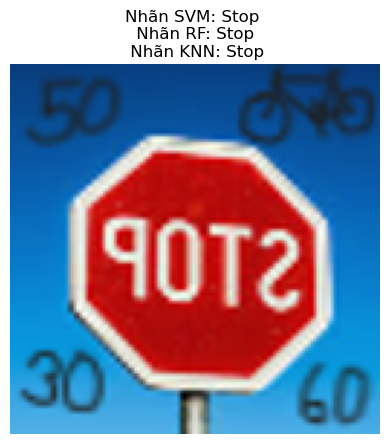

In [23]:
import matplotlib.pyplot as plt

# Chuẩn bị ảnh đầu vào (đã được tiền xử lý)
input_image = './data/d.png'  # Điền vào ảnh đầu vào của bạn
image = Image.open(input_image)
image = image.resize((128, 128))
hogI = compute_hog(input_image)
hogI = hogI.reshape(1, -1)
# Dự đoán nhãn của ảnh đầu vào
pred_svm = model_svm.predict(hogI)
pred_rf = model_rf.predict(hogI)
pred_knn = model_knn.predict(hogI)

# Hiển thị ảnh đầu vào và nhãn dự đoán
plt.imshow(image, cmap='gray')
plt.title(f'Nhãn SVM: {classes[pred_svm[0]]} \n Nhãn RF: {classes[pred_rf[0]]} \n Nhãn KNN: {classes[pred_knn[0]]}' ) 
plt.axis('off')
plt.show()

# Thực hiện tối ưu mô hình SVM

### Kiểm tra overfitting

In [24]:
# Đánh giá hiệu suất trên tập huấn luyện
train_accuracy = model_svm.score(x_train, y_train)

# Đánh giá hiệu suất trên tập kiểm thử
test_accuracy = model_svm.score(x_val, y_val)

print("Đánh giá hiệu suất:")
print(f"Độ chính xác trên tập huấn luyện: {train_accuracy}")
print(f"Độ chính xác trên tập kiểm thử: {test_accuracy}")

Đánh giá hiệu suất:
Độ chính xác trên tập huấn luyện: 0.999439461883408
Độ chính xác trên tập kiểm thử: 0.9875730994152047


In [64]:
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt

# Danh sách các giá trị của siêu tham số cần điều chỉnh
param_grid = {'C': [0.01, 0.03, 0.05, 0.07, 0.1]}

# Tạo GridSearchCV với mô hình SVM và siêu tham số đã cho
grid_search = GridSearchCV(estimator=model_svm, param_grid=param_grid, cv=5)

# Huấn luyện GridSearchCV trên dữ liệu
grid_search.fit(x_train, y_train)

# Lấy kết quả của Grid Search
results = grid_search.cv_results_

d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Setting_code\anaconda3\envs\myenv\Lib\site-packages\sklearn\svm\_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
d:\Setting_c

In [65]:
# Lấy mô hình tốt nhất
best_model = grid_search.best_estimator_

# Lưu mô hình tốt nhất
joblib_file = "best_svm_model.pkl"
dump(best_model, joblib_file)

['best_svm_model.pkl']

In [66]:
results_df = pd.DataFrame(results)
results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,105.309710,3.086391,0.108922,0.018388,0.01,{'C': 0.01},0.988303,0.987572,0.988545,0.987083,0.986839,0.987668,0.000665,1
1,120.743599,4.556787,0.099031,0.014517,0.03,{'C': 0.03},0.987815,0.987815,0.988058,0.986961,0.987326,0.987595,0.000396,2
2,129.703251,1.534369,0.101500,0.011794,0.05,{'C': 0.05},0.987937,0.986841,0.987814,0.986351,0.986595,0.987108,0.000647,3
3,145.628859,1.147720,0.084680,0.015476,0.07,{'C': 0.07},0.988181,0.986353,0.987692,0.985864,0.985986,0.986815,0.000942,4
4,165.300842,1.370400,0.083897,0.014479,0.1,{'C': 0.1},0.988425,0.986719,0.987570,0.985498,0.985255,0.986693,0.001205,5


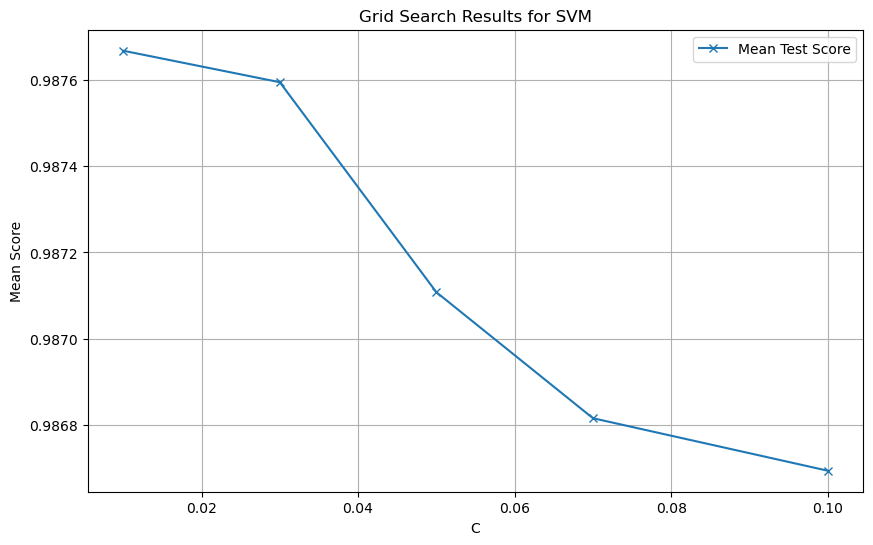

Best Parameters: {'C': 0.01}
Best Score: 0.987668148324307


In [124]:
plt.figure(figsize=(10, 6))
plt.plot(param_grid['C'], results['mean_test_score'], label='Mean Test Score', marker='x')
plt.xlabel('C')
plt.ylabel('Mean Score')
plt.title('Grid Search Results for SVM')
plt.legend()
plt.grid(True)
plt.show()

# Hiển thị siêu tham số tốt nhất và điểm số tương ứng
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Meta-model

In [75]:
from sklearn.linear_model import LogisticRegression

In [88]:
from sklearn.model_selection import train_test_split, KFold
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import numpy as np

# Khởi tạo các mô hình cơ sở
model_svm = SVC(probability=True)
model_rf = RandomForestClassifier()

## Base model 1

In [89]:
# Huấn luyện các mô hình cơ sở trên tập huấn luyện
model_svm.fit(x_train, y_train)

SVC(probability=True)

In [126]:
dump(model_svm, 'base_model_svm.pkl')

['base_model_svm.pkl']

## Base model 2

In [90]:
model_rf.fit(x_train, y_train)

RandomForestClassifier()

In [127]:
dump(model_rf, 'base_model_rf.pkl')

['base_model_rf.pkl']

In [91]:
# Sử dụng xác suất dự đoán từ các mô hình cơ sở
svm_train_prob = model_svm.predict_proba(x_train)
rf_train_prob = model_rf.predict_proba(x_train)

In [92]:
# Sử dụng xác suất dự đoán từ các mô hình cơ sở
svm_test_prob = model_svm.predict_proba(x_test)
rf_test_prob = model_rf.predict_proba(x_test)

In [121]:
svm_predictions = np.argmax(svm_test_prob, axis=1)
rf_predictions = np.argmax(rf_test_prob, axis=1)

In [122]:
svm_accuracy = accuracy_score(y_test, svm_predictions)
rf_accuracy = accuracy_score(y_test, rf_predictions)

## Đánh giá lại 2 base model

In [123]:
print(svm_accuracy)
print(rf_accuracy)

0.942596991290578
0.9338875692794932


## Tạo ma trận đặc trưng

In [98]:
# Kết hợp xác suất dự đoán để tạo thành ma trận đặc trưng đầu vào cho mô hình tổng hợp
train_stacked_features = np.hstack((svm_train_prob, rf_train_prob))
test_stacked_features = np.hstack((svm_test_prob, rf_test_prob))

## Huấn luyện meta-model

In [99]:
# Huấn luyện mô hình tổng hợp (ví dụ: Logistic Regression) trên tập huấn luyện
stacked_model = LogisticRegression()
stacked_model.fit(train_stacked_features, y_train)

LogisticRegression()

In [100]:
# Đưa ra dự đoán từ mô hình tổng hợp trên tập kiểm tra
stacked_predictions = stacked_model.predict(test_stacked_features)

In [102]:
# Đánh giá hiệu suất của mô hình tổng hợp
stacked_accuracy = accuracy_score(y_test, stacked_predictions)
print("Accuracy of stacked model:", stacked_accuracy)

Accuracy of stacked model: 0.9451702296120348


In [103]:
dump(stacked_model, 'stacked_model.pkl')

['stacked_model.pkl']

In [131]:
svm = load('base_model_svm.pkl')
rf = load('base_model_rf.pkl')
st = load('stacked_model.pkl')

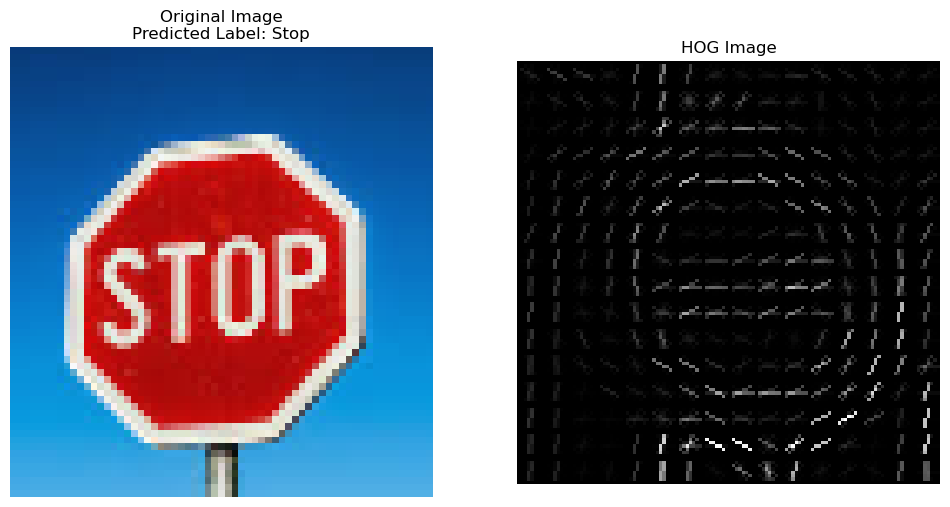

In [132]:
def predict_label(image_path):
    # Đọc và tiền xử lý ảnh
    features = compute_hog(image_path)
    
    # Sử dụng các mô hình cơ sở để tạo dự đoán xác suất
    svm_prob = svm.predict_proba([features])
    rf_prob = rf.predict_proba([features])
    
    # Kết hợp xác suất dự đoán để tạo thành ma trận đặc trưng đầu vào cho mô hình tổng hợp
    stacked_features = np.hstack((svm_prob, rf_prob))
    
    # Đưa ra dự đoán từ mô hình tổng hợp
    label = st.predict(stacked_features)
    
    return label[0]

# Đường dẫn tới ảnh cần dự đoán
image_path = './data/c.png'

# Dự đoán nhãn và lấy ảnh HOG
label = predict_label(image_path)

# Hiển thị ảnh gốc và ảnh HOG
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].imshow(Image.open(image_path))
ax[0].set_title(f"Original Image\nPredicted Label: {classes[label]}")
ax[0].axis('off')

ax[1].imshow(hog_image, cmap='gray')
ax[1].set_title("HOG Image")
ax[1].axis('off')

plt.show()

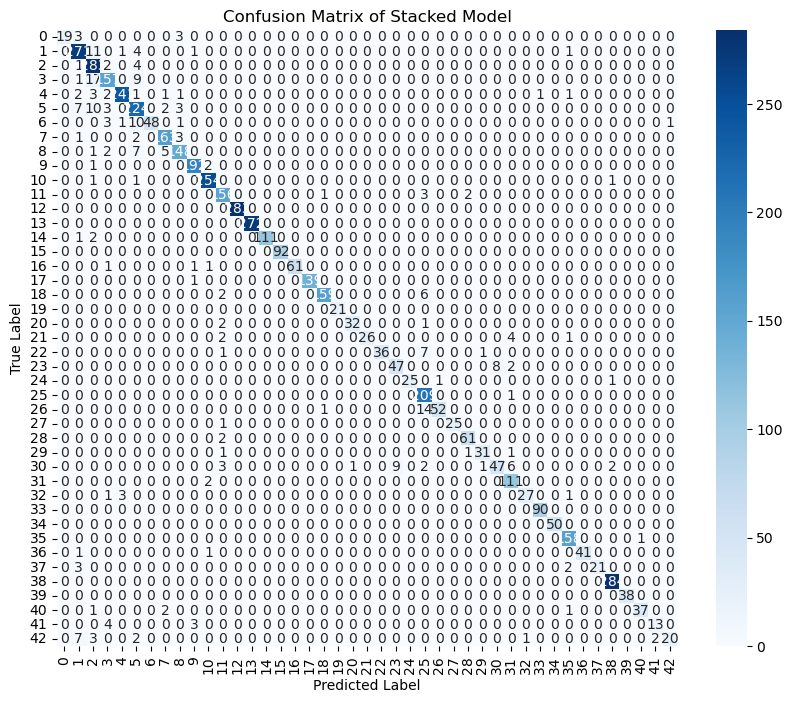

In [134]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dự đoán xác suất từ các mô hình cơ sở
svm_test_prob = svm.predict_proba(x_test)
rf_test_prob = rf.predict_proba(x_test)

# Kết hợp xác suất dự đoán để tạo thành ma trận đặc trưng đầu vào cho mô hình tổng hợp
test_stacked_features = np.hstack((svm_test_prob, rf_test_prob))

# Dự đoán từ mô hình tổng hợp trên tập kiểm tra
stacked_predictions = stacked_model.predict(test_stacked_features)

# Tính toán confusion matrix
conf_matrix = confusion_matrix(y_test, stacked_predictions)

# Vẽ confusion matrix sử dụng seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix of Stacked Model')
plt.show()
